# Mercado Livre API - Visitas às páginas dos produtos
Esse notebook apresenta visitas a itens resultantes de uma query definida pelo usuário. É possível ajustar o número de itens a serem plotados no gráfico (*ITEMS_TO_PLOT*), bem como o número de dias atrás que se deseja iniciar a consulta (*DAYS_AGO*).

O código é composto por 3 partes:

### Busca de itens a partir de uma query definida pelo usuário

- Get dos resultados da busca
- Ordenamento dos itens por mais vendidos e remoção de itens duplicados
- Corte de itens pelo limite *ITEMS_TO_PLOT*

### Request por visitas dos itens filtrados e ordenados

- Get das visitas dos itens desde *DAYS_AGO* dias atrás 
- Organização dos resultados em um único **df** indexado por data
- Headers das colunas editados para serem as ids dos itens

### Visualização dos dados de 3 formas
- Visitas por dia (básico)
- Média móvel de visitas (janela da média definida no código, ainda hardcoded)
- Soma acumulada de visitas

Ao final são listados os títulos dos itens e respectivas URLs para visualização da página.

## Imports e configurações gerais

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import requests
import pandas as pd

from pandas import Series, DataFrame

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10 # increases figure size
matplotlib.rcParams.update({'font.size': 16}) # increases chart font size

## Parâmetros de entrada

In [2]:
# Sets input parameters 
DAYS_AGO = 365 # days to look back in visits history
ITEMS_TO_PLOT = 10 # list of "ITEMS_TO_PLOT" top sold items; e.g. if 10, visits from top 10 sold itens will be plotted

## Busca de itens a partir de uma query definida pelo usuário

- Get dos resultados da busca
- Ordenamento dos itens por mais vendidos e remoção de itens duplicados
- Corte de itens pelo limite *ITEMS_TO_PLOT*

In [3]:
### REQUEST: gets items according to search for 'query' 

#query = "kit painel solar"
query = input('Qual a query desejada? ')

url = "https://api.mercadolibre.com/sites/MLB/search?q="+query
data = requests.get(url).json()

results = data["results"] # saves content from json in variable
df = DataFrame(results) # converts to a pandas df

df = df[["id", "title", "price", "sold_quantity", "available_quantity", "permalink"]] # gets only interesting columns

# sorts items by sold quantity and deletes duplicates with less sales (assuming they'd be 0)
df = df.sort_values(by="sold_quantity", ascending=False)
df = df.drop_duplicates(subset=['title'], keep='first')

ids = df.id.values[0:ITEMS_TO_PLOT] # gets top sold items ML ids in a list

df = df.set_index('id') # sets index to id

df.head()

Qual a query desejada? kit painel solar


,title,price,sold_quantity,available_quantity,permalink
id,,,,,
MLB712968328,Kit Painel Solar Fotovoltaico E Controlador De...,354.9,97,6,http://produto.mercadolivre.com.br/MLB-7129683...
MLB684532632,Kit Demonstrativo Célula Painel Placa Energia ...,29.9,69,950,http://produto.mercadolivre.com.br/MLB-6845326...
MLB695065272,Kit Painel Solar Placa Célula Fotovoltaica 150...,1459.0,54,964,http://produto.mercadolivre.com.br/MLB-6950652...
MLB754575430,Kit Painel Solar Com Bateria + Lampadas Led + ...,695.0,25,27,http://produto.mercadolivre.com.br/MLB-7545754...
MLB727650542,Kit Painel Placa Energia Solar 150w + Controla...,829.0,17,11,http://produto.mercadolivre.com.br/MLB-7276505...


## Request por visitas dos itens filtrados e ordenados

- Get das visitas dos itens desde *DAYS_AGO* dias atrás 
- Organização dos resultados em um único **df** indexado por data
- Headers das colunas editados para serem as ids dos itens

In [4]:
#### REQUEST: get visits (by days) for the items in 'ids'

days = DAYS_AGO # number of days ago to consider
ids_string = ','.join(ids) # makes comma-separated string from list to use in URL

url = 'https://api.mercadolibre.com/items/visits/time_window?ids=' + ids_string +'&last=' + str(days) + '&unit=day'
data = requests.get(url).json()

visits_df = DataFrame(data[0]['results']) # initialize a df with the first item out of 10 (top ten in ids_string)
visits_df = visits_df[['date', 'total']] # gets only main columns
visits_df.columns = ['date', data[0]['item_id']] # renames 'total' to item's ID

column_headers = [] # list to store item ids used as column headers
column_headers.append(data[0]['item_id'])

# iterates over data items to merge all 'total' columns into same df
for item in data[1:]:
    results = item['results']
    df_temp = DataFrame(results)
    df_temp = df_temp[['date', 'total']]
    df_temp.columns = ['date', item['item_id']]
    column_headers.append(item['item_id'])
    visits_df = pd.merge(visits_df, df_temp, on='date')
    
#print(column_headers)
#visits_df.head()

In [5]:
# fixes df, parsing 'date' properly and setting as index column
visits_df['date'] = pd.to_datetime(visits_df['date'])
visits_df = visits_df.set_index('date')

visits_df.head()

,MLB712968328,MLB684532632,MLB695065272,MLB754575430,MLB727650542,MLB765601179,MLB773028235,MLB699427412,MLB767638167,MLB760365541
date,,,,,,,,,,
2015-10-09 04:00:00,118,7,116,0,0,0,0,73,0,0
2015-10-10 04:00:00,125,12,119,0,0,0,0,54,0,0
2015-10-11 04:00:00,83,17,127,0,0,0,0,56,0,0
2015-10-12 04:00:00,0,24,194,0,0,0,0,92,0,0
2015-10-13 04:00:00,111,19,185,0,0,0,0,93,0,0


## Visualização dos dados de 3 formas
- Visitas por dia (básico)
- Média móvel de visitas (janela da média definida no código, ainda hardcoded)
- Soma acumulada de visitas

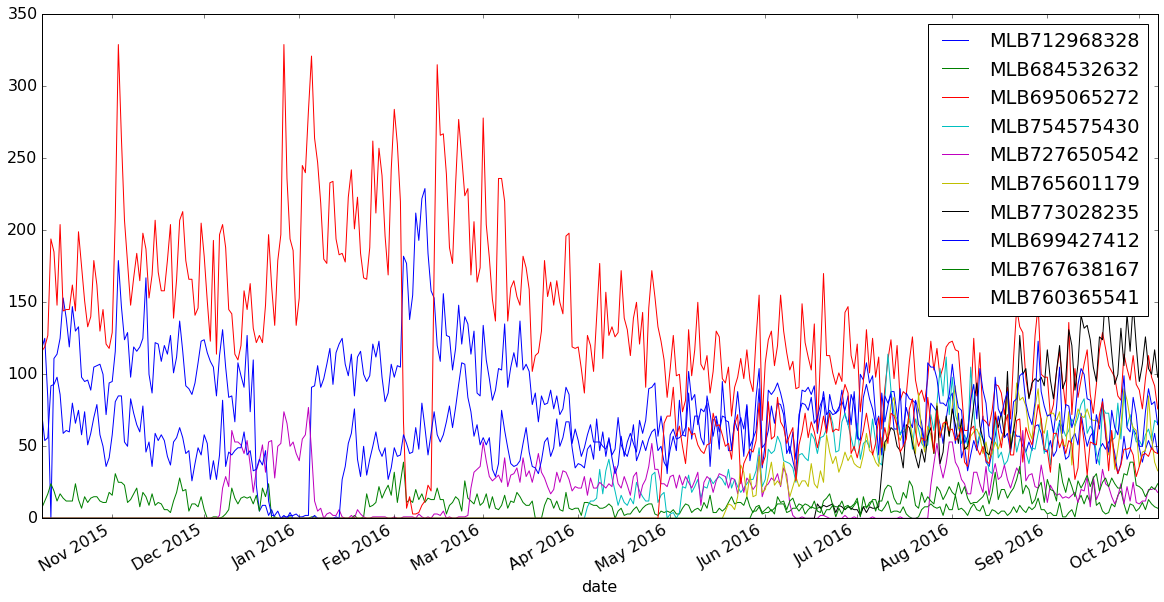

In [6]:
plt.figure()
visits_df.plot(legend=True);

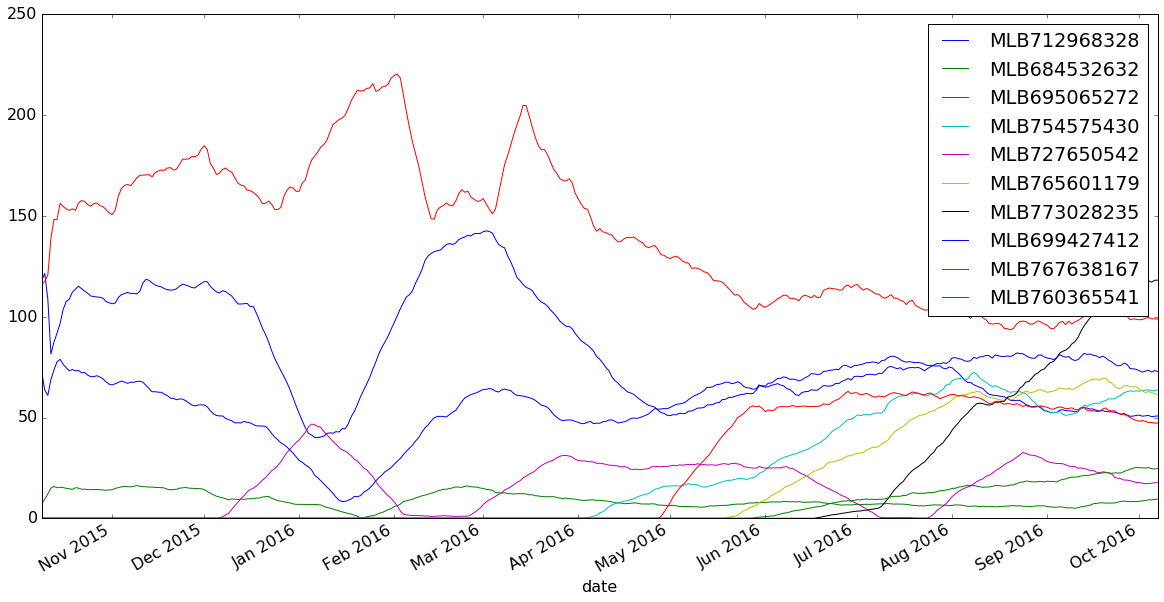

In [7]:
# calculates and plots visits' rolling mean (smoother curves)
#rolling_mean_df = visits_df.resample("1d").sum().fillna(0).rolling(window=30, min_periods=1).mean() #when resampling is needed

plt.figure();
rolling_mean_df = visits_df.rolling(window=30, min_periods=1).mean() # window is the # of days evaluated in rolling mean
rolling_mean_df.plot();

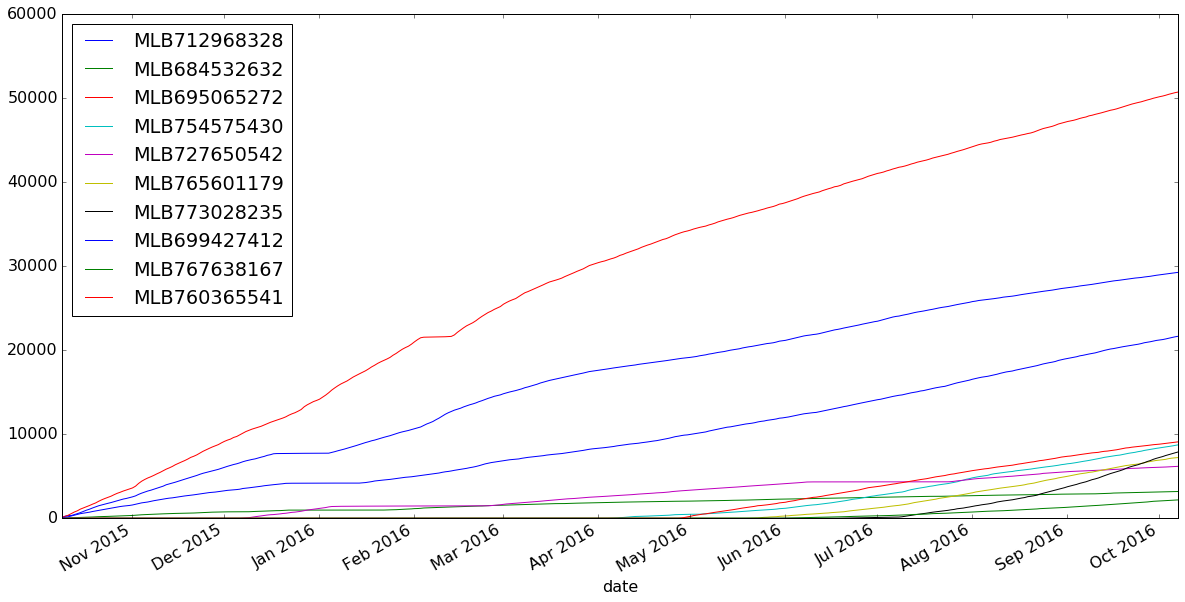

In [8]:
cumulative_visits_df = visits_df.cumsum() # calculates accumulated values to plot
plt.figure();
cumulative_visits_df.plot(legend=True);

## Lista dos itens plotados e URLs

In [9]:
# prints URLs from items in chart

print('URLs dos itens plotados:', '\n')
for item in column_headers:
    print(item + ' - ' + df.loc[item, 'title']) # uses loc taking advantage of indexing by id made previously
    print(df.loc[item, 'permalink'])
    

URLs dos itens plotados: 

MLB712968328 - Kit Painel Solar Fotovoltaico E Controlador De Carga
http://produto.mercadolivre.com.br/MLB-712968328-kit-painel-solar-fotovoltaico-e-controlador-de-carga-_JM
MLB684532632 - Kit Demonstrativo Célula Painel Placa Energia Solar 6v 150ma
http://produto.mercadolivre.com.br/MLB-684532632-kit-demonstrativo-celula-painel-placa-energia-solar-6v-150ma-_JM
MLB695065272 - Kit Painel Solar Placa Célula Fotovoltaica 150w + Acessórios
http://produto.mercadolivre.com.br/MLB-695065272-kit-painel-solar-placa-celula-fotovoltaica-150w-acessorios-_JM
MLB754575430 - Kit Painel Solar Com Bateria + Lampadas Led + Controlador
http://produto.mercadolivre.com.br/MLB-754575430-kit-painel-solar-com-bateria-lampadas-led-controlador-_JM
MLB727650542 - Kit Painel Placa Energia Solar 150w + Controlador 20a + Cabo
http://produto.mercadolivre.com.br/MLB-727650542-kit-painel-placa-energia-solar-150w-controlador-20a-cabo-_JM
MLB765601179 - Kit Placa Painel Solar 200w + Controlado